In [ ]:
# Run this cell to install DiffeRT and its dependencies, e.g., on Google Colab

try:
    import differt  # noqa: F401
except ImportError:
    import sys  # noqa: F401

    !{sys.executable} -m pip install differt[all]

# Ray Tracing at City Scale

In [2]:
import jax.numpy as jnp
import numpy as np
from tqdm.notebook import tqdm, trange
from vispy.scene.visuals import Image
from vispy.visuals.transforms import STTransform

import differt.plotting as dplt
from differt.geometry import TriangleMesh
from differt.geometry.triangle_mesh import (
    triangles_contain_vertices_assuming_inside_same_plane,
)
from differt.rt.image_method import (
    consecutive_vertices_are_on_same_side_of_mirrors,
    image_method,
)
from differt.rt.utils import (
    generate_all_path_candidates_chunks_iter,
    rays_intersect_any_triangle,
    rays_intersect_triangles,
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


RFBOutputContext()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CanvasBackend(css_height='600px', css_width='800px')
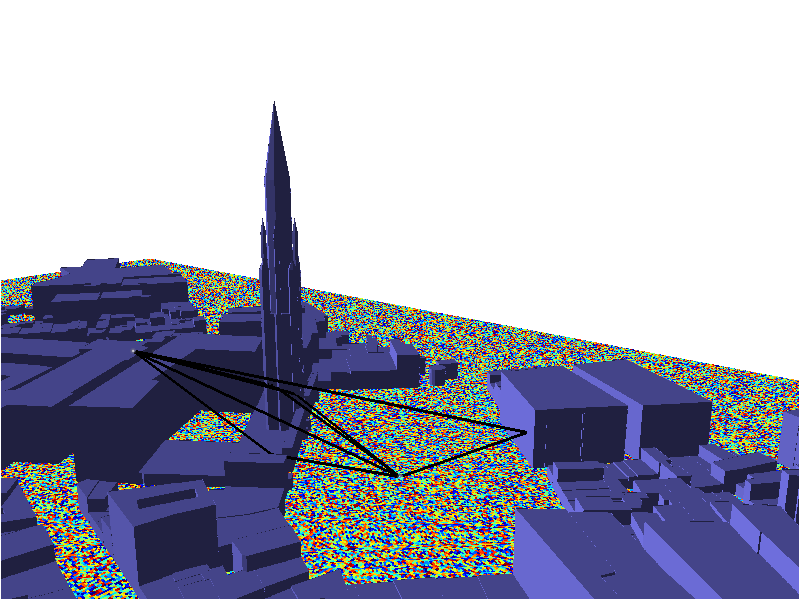

In [3]:
mesh_file = "bruxelles.obj"
mesh = TriangleMesh.load_obj(mesh_file)

canvas = mesh.plot()

tx = jnp.array([-40.0, 75, 30.0])
rx = jnp.array([+20.0, 108.034, 1.50])

dplt.draw_markers(np.array([tx, rx]), ["tx", "rx"], canvas=canvas)

color = ["black", "green", "orange", "yellow"]

all_triangle_vertices = jnp.take(mesh.vertices, mesh.triangles, axis=0)

rng = np.random.default_rng(1234)
image_np = rng.random(size=(1000, 1000), dtype=np.float32)

x = all_triangle_vertices[..., 0]
y = all_triangle_vertices[..., 1]


image = Image(image_np, interpolation="nearest", method="subdivide", cmap="jet")
image.transform = STTransform(
    scale=(abs(np.max(x) - np.min(x)) / 1000, abs(np.max(y) - np.min(y)) / 1000),
    translate=(np.min(x), np.min(y), 1.5),
)

num_triangles = mesh.triangles.shape[0]

for order in trange(
    0,
    2,
    leave=False,
):  # You probably don't want to try order > 1 (too slow if testing all paths)
    # Prepare input arrays
    for path_candidates in tqdm(
        generate_all_path_candidates_chunks_iter(
            num_triangles,
            order,
            chunk_size=2_000_000,
        ),
        leave=False,
    ):
        # print(f"{path_candidates.shape = }")
        num_path_candidates = path_candidates.shape[0]
        from_vertices = jnp.tile(tx, (num_path_candidates, 1))
        to_vertices = jnp.tile(rx, (num_path_candidates, 1))
        triangles = jnp.take(mesh.triangles, path_candidates, axis=0)
        triangle_vertices = jnp.take(mesh.vertices, triangles, axis=0)
        mirror_vertices = triangle_vertices[..., 0, :]
        mirror_normals = jnp.take(mesh.normals, path_candidates, axis=0)
        paths = image_method(
            from_vertices,
            to_vertices,
            mirror_vertices,
            mirror_normals,
        )
        # print(f"{paths.shape = }, {triangle_vertices.shape = }")
        mask = triangles_contain_vertices_assuming_inside_same_plane(
            triangle_vertices,
            paths,
        )
        mask = jnp.all(mask, axis=-1)
        full_paths = jnp.concatenate(
            (
                jnp.expand_dims(from_vertices[mask, ...], axis=-2),
                paths[mask, ...],
                jnp.expand_dims(to_vertices[mask, ...], axis=-2),
            ),
            axis=-2,
        )
        mask = consecutive_vertices_are_on_same_side_of_mirrors(
            full_paths,
            mirror_vertices[mask, ...],
            mirror_normals[mask, ...],
        )
        mask = jnp.all(mask, axis=-1)
        ray_origins = full_paths[..., :-1, :]
        ray_directions = jnp.diff(full_paths, axis=-2)
        ray_origins = jnp.repeat(
            jnp.expand_dims(ray_origins, axis=-2),
            num_triangles,
            axis=-2,
        )
        ray_directions = jnp.repeat(
            jnp.expand_dims(ray_directions, axis=-2),
            num_triangles,
            axis=-2,
        )
        t, hit = rays_intersect_triangles(
            ray_origins,
            ray_directions,
            jnp.broadcast_to(all_triangle_vertices, (*ray_origins.shape, 3)),
        )
        intersect = (t < 0.999) & hit
        intersect = jnp.any(intersect, axis=(-1, -2))
        mask = mask & ~intersect
        full_paths = full_paths[mask, ...]

        dplt.draw_paths(full_paths, canvas=canvas)

view = dplt.view_from_canvas(canvas)
view.add(image)
view.camera.set_state(
    {
        "scale_factor": 138.81554751457762,
        "center": (20.0, 108.034, 46.0),
        "fov": 45.0,
        "elevation": 13.0,
        "azimuth": 39.0,
        "roll": 0.0,
    },
)

canvas

RFBOutputContext()

CanvasBackend(css_height='600px', css_width='800px')
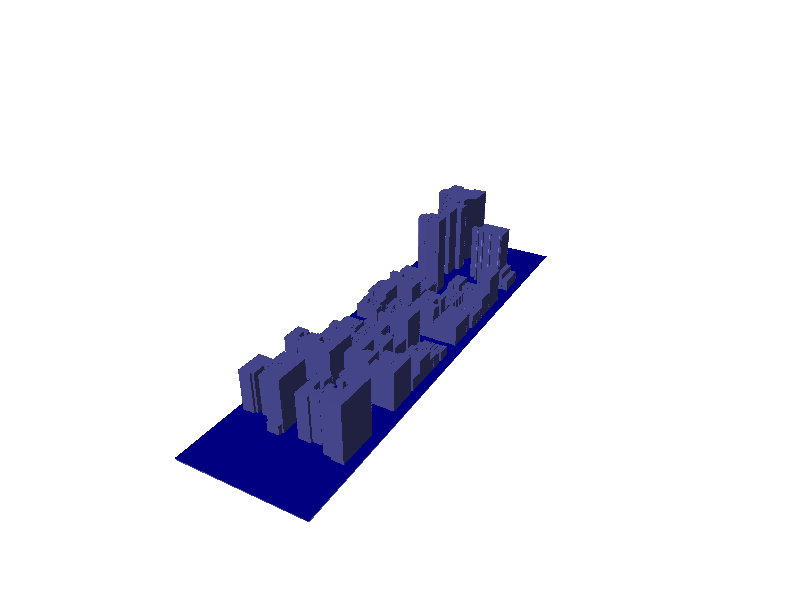

In [4]:
mesh_file = "manhattan.obj"
mesh = TriangleMesh.load_obj(mesh_file)

canvas = mesh.plot()

tx = jnp.array([-40.0, 75, 30.0])
rx = jnp.array([+20.0, 108.034, 1.50])

dplt.draw_markers(np.array([tx, rx]), ["tx", "rx"], canvas=canvas)

all_triangle_vertices = jnp.take(mesh.vertices, mesh.triangles, axis=0)

x_tri = all_triangle_vertices[..., 0]
y_tri = all_triangle_vertices[..., 1]

N = 125

x = jnp.linspace(x_tri.min(), x_tri.max(), N)
y = jnp.linspace(y_tri.min(), y_tri.max(), N)
X, Y = jnp.meshgrid(x, y)
Z = 1.5 * jnp.ones_like(X)
RX = jnp.stack((X, Y, Z), axis=-1)

power = jnp.zeros_like(X)

num_triangles = mesh.triangles.shape[0]

for order in range(
    0,
):  # You probably don't want to try order > 1 (too slow if testing all paths)
    # Prepare input arrays
    for path_candidates in generate_all_path_candidates_chunks_iter(
        num_triangles,
        order,
        chunk_size=1000,
    ):
        num_path_candidates = path_candidates.shape[0]
        from_vertices = jnp.tile(tx, (N, N, num_path_candidates, 1))
        to_vertices = jnp.tile(
            jnp.expand_dims(RX, axis=-2),
            (1, 1, num_path_candidates, 1),
        )
        path_candidates = jnp.tile(path_candidates, (N, N, 1, 1))
        triangles = jnp.take(mesh.triangles, path_candidates, axis=0)
        triangle_vertices = jnp.take(mesh.vertices, triangles, axis=0)
        mirror_vertices = triangle_vertices[..., 0, :]
        mirror_normals = jnp.take(mesh.normals, path_candidates, axis=0)
        paths = image_method(
            from_vertices,
            to_vertices,
            mirror_vertices,
            mirror_normals,
        )
        mask = triangles_contain_vertices_assuming_inside_same_plane(
            triangle_vertices,
            paths,
        )
        mask_1 = jnp.all(mask, axis=-1)
        full_paths = jnp.concatenate(
            (
                jnp.expand_dims(from_vertices, axis=-2),
                paths,
                jnp.expand_dims(to_vertices, axis=-2),
            ),
            axis=-2,
        )
        mask_2 = consecutive_vertices_are_on_same_side_of_mirrors(
            full_paths,
            mirror_vertices,
            mirror_normals,
        )
        mask_2 = jnp.all(mask_2, axis=-1)
        ray_origins = full_paths[..., :-1, :]
        ray_directions = jnp.diff(full_paths, axis=-2)
        intersect_any = rays_intersect_any_triangle(
            ray_origins,
            ray_directions,
            all_triangle_vertices,
        )
        mask_2 = mask_2 & ~jnp.any(intersect_any, axis=-1)
        mask = mask_1 & mask_2

        lengths = jnp.linalg.norm(full_paths, axis=-1).sum(axis=-1)
        power_per_path = 1.0 / (lengths * lengths)
        power_per_path *= mask.astype(power_per_path.dtype)

        # print(f"{power_per_path.shape = }")
        # print(f"{mask_1.shape = }")
        # print(f"{mask_2.shape = }")

        # print(lengths.shape)

        power += power_per_path.sum(axis=-1)


image = Image(power, interpolation="nearest", method="subdivide", cmap="jet")
image.transform = STTransform(
    scale=(abs(np.max(x) - np.min(x)) / N, abs(np.max(y) - np.min(y)) / N),
    translate=(np.min(x), np.min(y), 1.5),
)

view = dplt.view_from_canvas(canvas)
view.add(image)

canvas

RFBOutputContext()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CanvasBackend(css_height='600px', css_width='800px')
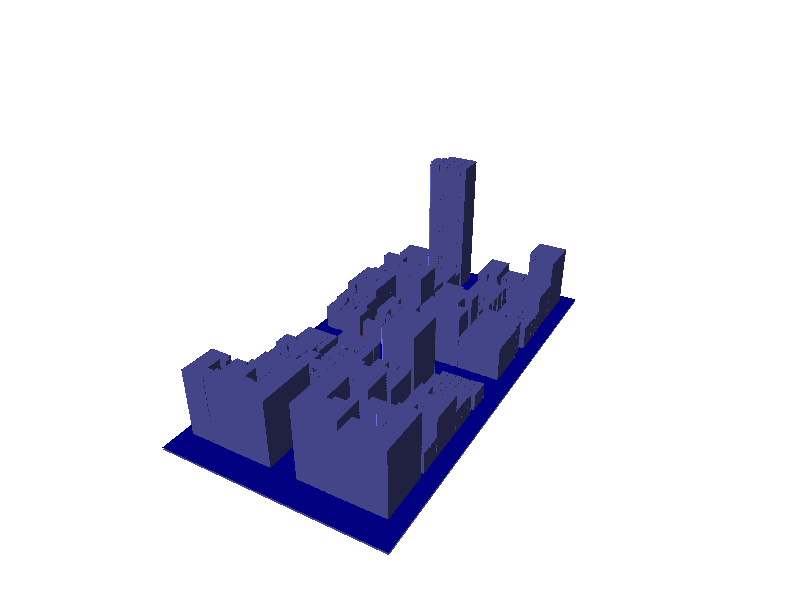

In [5]:
mesh_file = "manhattan_small.obj"
mesh = TriangleMesh.load_obj(mesh_file)

canvas = mesh.plot()
tx = jnp.array([-40.0, 75, 30.0])
rx = jnp.array([+20.0, 108.034, 1.50])

dplt.draw_markers(np.array([tx, rx]), ["tx", "rx"], canvas=canvas)

all_triangle_vertices = jnp.take(mesh.vertices, mesh.triangles, axis=0)

x_tri = all_triangle_vertices[..., 0]
y_tri = all_triangle_vertices[..., 1]

N = 125

x = jnp.linspace(x_tri.min(), x_tri.max(), N)
y = jnp.linspace(y_tri.min(), y_tri.max(), N)
X, Y = jnp.meshgrid(x, y)
Z = 1.5 * jnp.ones_like(X)
RX = jnp.stack((X, Y, Z), axis=-1)

power = jnp.zeros_like(X)

num_triangles = mesh.triangles.shape[0]

for order in trange(
    0,
    1,
    leave=False,
):  # You probably don't want to try order > 1 (too slow if testing all paths)
    # Prepare input arrays
    for path_candidates in tqdm(
        generate_all_path_candidates_chunks_iter(num_triangles, order, chunk_size=1000),
        leave=False,
    ):
        num_path_candidates = path_candidates.shape[0]
        from_vertices = jnp.tile(tx, (N, N, num_path_candidates, 1))
        to_vertices = jnp.tile(
            jnp.expand_dims(RX, axis=-2),
            (1, 1, num_path_candidates, 1),
        )
        path_candidates = jnp.tile(path_candidates, (N, N, 1, 1))
        triangles = jnp.take(mesh.triangles, path_candidates, axis=0)
        triangle_vertices = jnp.take(mesh.vertices, triangles, axis=0)
        mirror_vertices = triangle_vertices[..., 0, :]
        mirror_normals = jnp.take(mesh.normals, path_candidates, axis=0)
        paths = image_method(
            from_vertices,
            to_vertices,
            mirror_vertices,
            mirror_normals,
        )
        mask = triangles_contain_vertices_assuming_inside_same_plane(
            triangle_vertices,
            paths,
        )
        mask_1 = jnp.all(mask, axis=-1)
        full_paths = jnp.concatenate(
            (
                jnp.expand_dims(from_vertices, axis=-2),
                paths,
                jnp.expand_dims(to_vertices, axis=-2),
            ),
            axis=-2,
        )
        mask_2 = consecutive_vertices_are_on_same_side_of_mirrors(
            full_paths,
            mirror_vertices,
            mirror_normals,
        )
        mask_2 = jnp.all(mask_2, axis=-1)
        ray_origins = full_paths[..., :-1, :]
        ray_directions = jnp.diff(full_paths, axis=-2)
        intersect_any = rays_intersect_any_triangle(
            ray_origins,
            ray_directions,
            all_triangle_vertices,
        )
        mask_2 = mask_2 & ~jnp.any(intersect_any, axis=-1)
        mask = mask_1 & mask_2

        lengths = jnp.linalg.norm(full_paths, axis=-1).sum(axis=-1)
        power_per_path = 1.0 / (lengths * lengths)
        power_per_path *= mask.astype(power_per_path.dtype)

        # print(f"{power_per_path.shape = }")
        # print(f"{mask_1.shape = }")
        # print(f"{mask_2.shape = }")

        # print(lengths.shape)

        power += power_per_path.sum(axis=-1)


image = Image(power, interpolation="nearest", method="subdivide", cmap="jet")
image.transform = STTransform(
    scale=(abs(np.max(x) - np.min(x)) / N, abs(np.max(y) - np.min(y)) / N),
    translate=(np.min(x), np.min(y), 1.5),
)

view = dplt.view_from_canvas(canvas)
view.add(image)

canvas